Opening raw data file C:/Users/pc/Desktop/李佳/S002/Subject_001.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   374.994 secs
Ready.
Reading 0 ... 59999  =      0.000 ...   374.994 secs...


C:\Users\pc\AppData\Local\Temp\ipykernel_5188\1776712701.py:84: RuntimeWarning: This filename (C:/Users/pc/Desktop/李佳/S002/Subject_001.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


Fitting ICA to data using 64 channels (please be patient, this may take a while)


C:\Users\pc\AppData\Local\Temp\ipykernel_5188\1776712701.py:111: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 20 components
Fitting ICA took 1.4s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated


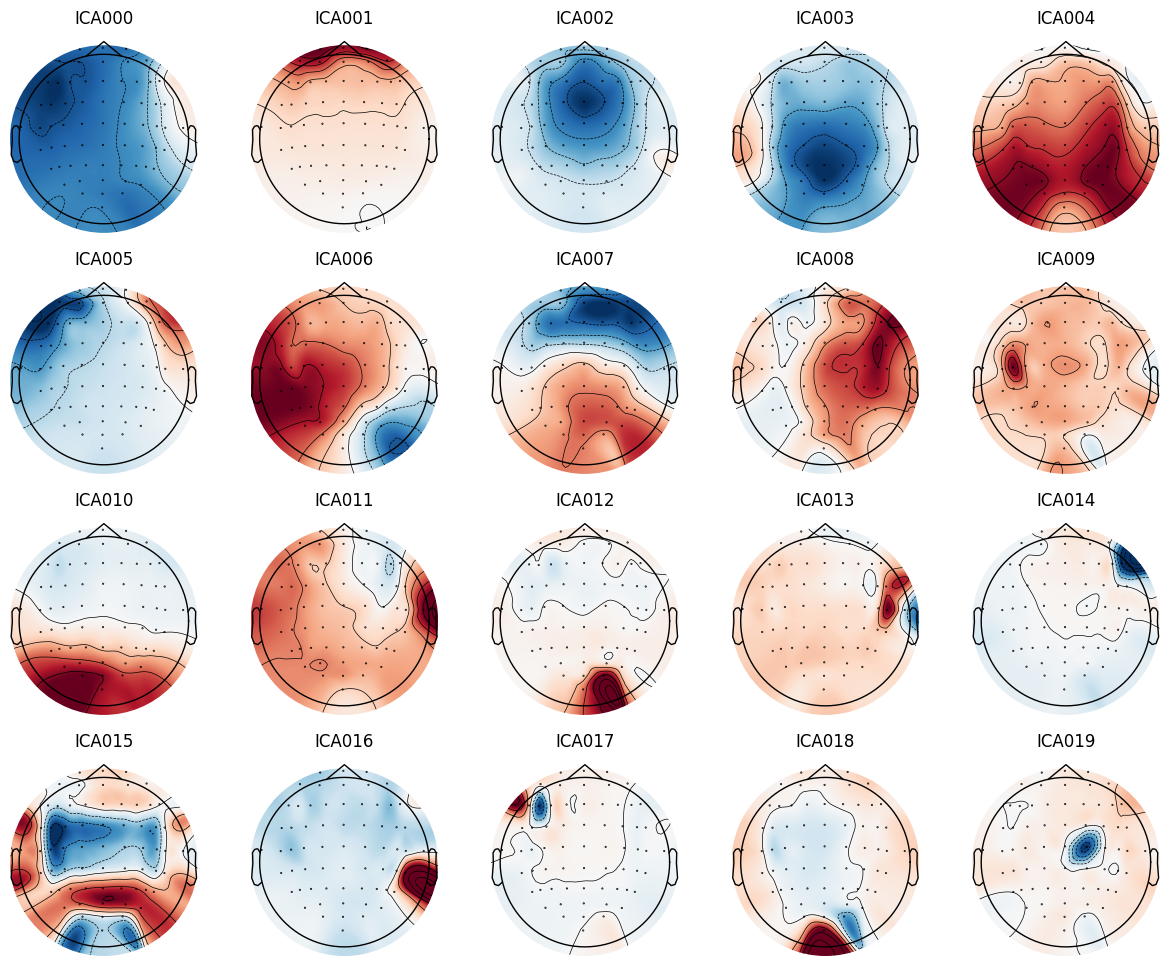

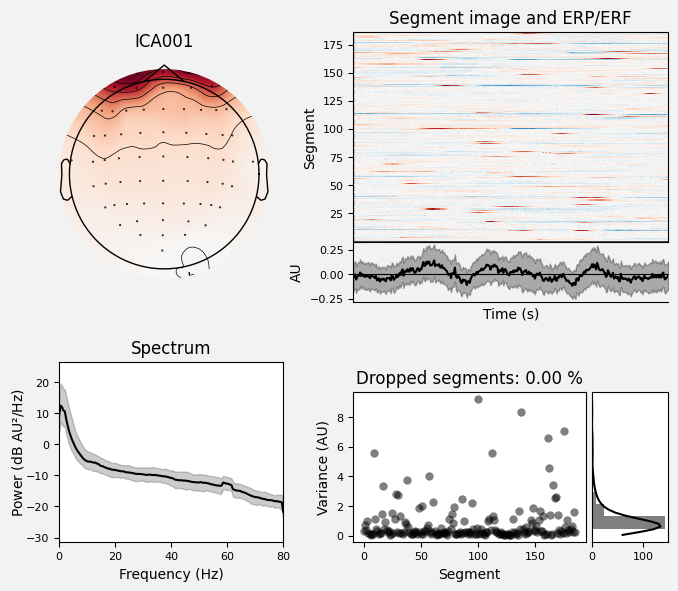

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated


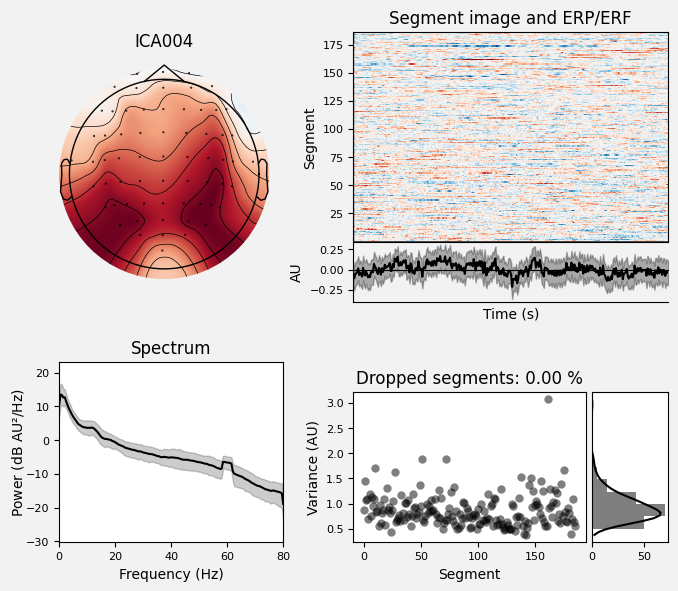

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated


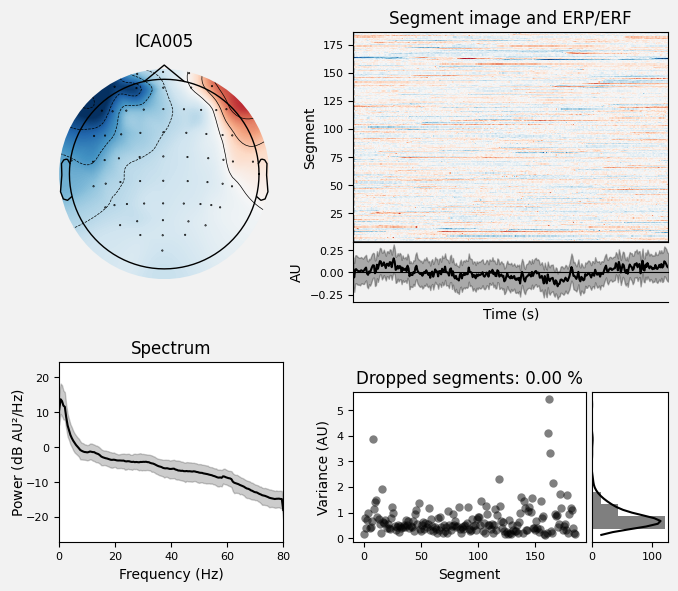

In [3]:
import mne
from mne.preprocessing import ICA
from mne.datasets import eegbci
import tkinter as tk
from tkinter import filedialog, ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import matplotlib
import os

# matplotlib.use('TkAgg')

# 创建主窗口
root = tk.Tk()
root.title("ICA处理GUI")

# 全局变量
raw_list = []
ica = None
fig = None
axes = None
canvas = None

# 默认ICA参数
n_components = 7
max_iter = 1000

def reset_state():
    global raw_list, ica, fig, axes, canvas
    raw_list = []
    ica = None
    if fig is not None:
        plt.close(fig)
    fig = None
    axes = None
    canvas = None

def create_ica_plot_window():
    global fig, axes, canvas
    if fig is not None:
        plt.close(fig)
    
    plot_window = tk.Toplevel(root)
    plot_window.title("ICA图像")

    n_cols = 5
    n_rows = (n_components + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows))
    canvas = FigureCanvasTkAgg(fig, master=plot_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def update_ica_plot():
    if fig is None or axes is None or canvas is None:
        create_ica_plot_window()
    
    for ax in axes.flatten():
        ax.clear()
    
    ica.plot_components(inst=raw_list[0], axes=axes.flatten()[:n_components], show=False)
    canvas.draw()

def load_eeg_files():
    reset_state()
    file_format = format_var.get()
    if file_format == "EDF":
        filetypes = [("EDF文件", "*.edf")]
    elif file_format == "BDF":
        filetypes = [("BDF文件", "*.bdf")]
    elif file_format == "FIF":
        filetypes = [("FIF文件", "*.fif")]
    else:
        filetypes = [("所有支持的格式", "*.edf *.bdf *.fif")]

    filepaths = filedialog.askopenfilenames(title="选择EEG文件", filetypes=filetypes)
    if filepaths:
        for filepath in filepaths:
            if filepath.endswith('.edf'):
                raw = mne.io.read_raw_edf(filepath, preload=True)
            elif filepath.endswith('.bdf'):
                raw = mne.io.read_raw_bdf(filepath, preload=True)
            elif filepath.endswith('.fif'):
                raw = mne.io.read_raw_fif(filepath, preload=True)
            else:
                tk.Label(root, text=f"不支持的文件格式: {filepath.split('/')[-1]}").pack()
                continue
            
            eegbci.standardize(raw)
            
            montage_name = montage_var.get()
            montage = mne.channels.make_standard_montage(montage_name)
            raw.set_montage(montage)
            raw_list.append(raw)
            tk.Label(root, text=f"已加载: {filepath.split('/')[-1]} 使用montage: {montage_name}").pack()

def run_ica():
    global ica
    global n_components, max_iter
    if not raw_list:
        tk.Label(root, text="请先加载EEG文件").pack()
        return
    
    n_components = int(n_components_entry.get())
    max_iter = int(max_iter_entry.get())

    create_ica_plot_window()

    for raw in raw_list:
        ica = ICA(n_components=n_components, random_state=97, max_iter=max_iter, method='fastica')
        ica.fit(raw)
        update_ica_plot()

def update_ica_plot():
    if fig is None or axes is None or canvas is None:
        create_ica_plot_window()
    
    for ax in axes.flatten():
        ax.clear()
    
    ica.plot_components(inst=raw_list[0], axes=axes.flatten()[:n_components], show=False)
    canvas.draw()

def exclude_muscle_artifacts():
    global ica
    if not raw_list:
        tk.Label(root, text="请先加载EEG文件").pack()
        return
    for raw in raw_list:
        ica = ICA(n_components=n_components, random_state=97, max_iter=max_iter, method='fastica')
        ica.fit(raw)
        muscle_idx_auto, scores = ica.find_bads_muscle(raw)
        ica.exclude = muscle_idx_auto
        ica.apply(raw)
        tk.Label(root, text="已排除肌肉伪影的成分").pack()

def exclude_components():
    global ica
    if ica is None:
        tk.Label(root, text="请先运行ICA").pack()
        return
    
    exclude_indices = exclude_entry.get()
    try:
        exclude_indices = [int(idx) for idx in exclude_indices.split()]
    except ValueError:
        tk.Label(root, text="请输入有效的成分索引，用空格分隔").pack()
        return
    
    ica.exclude = exclude_indices
    for raw in raw_list:
        ica.apply(raw)
    tk.Label(root, text=f"已剔除成分: {exclude_indices}").pack()

def save_processed_data():
    if not raw_list:
        tk.Label(root, text="请先加载EEG文件").pack()
        return
    
    save_path = save_path_entry.get()
    custom_name = custom_name_entry.get()
    if not save_path or not custom_name:
        tk.Label(root, text="请输入有效的保存路径和文件名").pack()
        return
    
    raw = raw_list[0]
    file_path = f"{save_path}/{custom_name}_ICA_{n_components}_{max_iter}_processed.fif"
    
    if os.path.exists(file_path):
        response = messagebox.askyesno("文件已存在", f"文件 {file_path} 已存在，是否覆盖？")
        if not response:
            return
    
    raw.save(file_path, overwrite=True)
    tk.Label(root, text=f"已保存处理后的数据到: {file_path}").pack()

def close_app():
    if fig is not None:
        plt.close(fig)
    root.destroy()

root.protocol("WM_DELETE_WINDOW", close_app)

# 创建GUI元素
montage_var = tk.StringVar(value='standard_1005')
montage_options = ['standard_1005', 'standard_1020', 'biosemi64', 'easycap-M1']
format_var = tk.StringVar(value='ALL')
format_options = ['ALL', 'EDF', 'BDF', 'FIF']

tk.Label(root, text="选择EEG数据格式:").pack(pady=5)
format_menu = ttk.Combobox(root, textvariable=format_var, values=format_options)
format_menu.pack(pady=5)

tk.Label(root, text="选择montage系统:").pack(pady=5)
montage_menu = ttk.Combobox(root, textvariable=montage_var, values=montage_options)
montage_menu.pack(pady=5)

tk.Label(root, text="选择ICA成分数:").pack(pady=5)
n_components_entry = tk.Entry(root)
n_components_entry.insert(0, "7")
n_components_entry.pack(pady=5)

tk.Label(root, text="选择ICA最大迭代次数:").pack(pady=5)
max_iter_entry = tk.Entry(root)
max_iter_entry.insert(0, "1000")
max_iter_entry.pack(pady=5)

tk.Button(root, text="加载EEG文件", command=load_eeg_files).pack(pady=10)
tk.Button(root, text="排除肌肉伪影", command=exclude_muscle_artifacts).pack(pady=10)
tk.Button(root, text="运行ICA", command=run_ica).pack(pady=10)

tk.Label(root, text="输入要剔除的成分索引（用空格分隔）:").pack(pady=5)
exclude_entry = tk.Entry(root)
exclude_entry.pack(pady=5)
tk.Button(root, text="剔除成分", command=exclude_components).pack(pady=10)

tk.Label(root, text="输入保存处理后数据的地址:").pack(pady=5)
save_path_entry = tk.Entry(root)
save_path_entry.pack(pady=5)

tk.Label(root, text="输入自定义文件名:").pack(pady=5)
custom_name_entry = tk.Entry(root)
custom_name_entry.pack(pady=5)

tk.Button(root, text="保存处理后的数据", command=save_processed_data).pack(pady=10)

tk.Button(root, text="关闭", command=close_app).pack(pady=10)

# 运行GUI主循环
root.mainloop()